<a href="https://colab.research.google.com/github/reedmarkham/meter-made/blob/main/meter_made.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import geopandas as gpd
import folium
import branca.colormap as cm
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Load the DC parking data previously downloaded to Google Drive

In [4]:
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/MyDrive/dc-parking-data'

Mounted at /content/drive
Accessible_Parking_Zones.geojson		    Parking_Zones.geojson
Address_Points.geojson				    Residential_and_Visitor_Parking_Zones.geojson
Parking_Blockface.geojson			    Roadway_Blockface.geojson
Parking_Violations_Issued_in_December_2024.geojson  Street_Right_Of_Way.geojson
Parking_Violations_Issued_in_June_2024.geojson	    Valet_Parking.geojson


# Check out the DC parking zones (street sweeping routes)

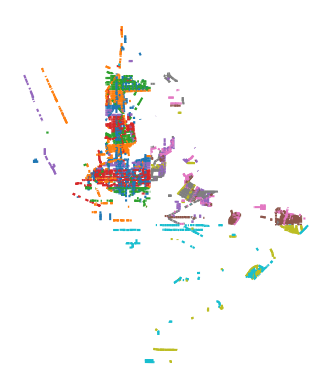

In [5]:
zones = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Zones.geojson')
ax = zones[zones.PARKINGGROUP == 'Sweeping'].plot(column='ROUTEID')
ax.set_axis_off()

Ingest addresses and routes

In [9]:
addresses = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Address_Points.geojson')
a_cols = ['ADDRESS', 'ZIPCODE', 'BLOCKKEY', 'ROUTEID', 'LATITUDE', 'LONGITUDE']
addresses = addresses[a_cols]

# & (gdf.ROUTEID == '11072862')
routes = zones[(zones.PARKINGGROUP == 'Sweeping') & (zones.PARKINGDAYGROUP == 'Monday') & (zones.PARKINGHOURGROUP == 'AM')].set_crs('EPSG:4326')
routes = routes.sort_values(by='MEAS_FROM')
r_cols = ['ROUTEID', 'ZONEID', 'SIGNS', 'SIGNTEXT', 'SIGNCODE', 'MEAS_FROM', 'MEAS_TO', 'STARTTIME', 'ENDTIME', 'BLOCKFACEKEY', 'geometry']
routes = routes[r_cols]

routes_df = routes.merge(addresses, on='ROUTEID', how='inner')
routes_gdf = gpd.GeoDataFrame(
    routes_df,
    geometry=gpd.points_from_xy(routes_df.LONGITUDE, routes_df.LATITUDE),
    crs='EPSG:4326'
)

display(routes_gdf.sort_values(by='ADDRESS'))

,ROUTEID,ZONEID,SIGNS,SIGNTEXT,SIGNCODE,MEAS_FROM,MEAS_TO,STARTTIME,ENDTIME,BLOCKFACEKEY,geometry,ADDRESS,ZIPCODE,BLOCKKEY,LATITUDE,LONGITUDE
162405,11068382,b17df5ba43d9090d7fb1c6888ad5710c-left-1,"69707B76,9406DFDD",,R-NS-022,2436.798096,2517.250244,23.0,31.0,b17df5ba43d9090d7fb1c6888ad5710c,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
174799,11068382,5a1ef58455d9e8f59882cd6be3db8cec-left-0,"6C18511A,B49A4FF8,06C552E7,D85114EC",None,R-NS-022,2589.184814,2700.219482,23.0,31.0,5a1ef58455d9e8f59882cd6be3db8cec,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
223608,11068382,b29d88b46d5cd801e5007dc09163857f-right-2,"C4A733FA,E70DB290,2A48C50B,1FB37F0B,430D2FE0",,R-NS-022,3543.365479,3701.366455,23.0,31.0,b29d88b46d5cd801e5007dc09163857f,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
157253,11068382,84cf5ad23b44a52bbab608c63339bc8e-left-1,"BDA72933,74D960FB",,R-NS-022,2336.048096,2425.520508,23.0,31.0,84cf5ad23b44a52bbab608c63339bc8e,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
171602,11068382,46a76de4c58cce77f347c18c4d4d3525-left-0,DB9F1379,,R-NS-022,2529.746826,2576.688232,23.0,31.0,46a76de4c58cce77f347c18c4d4d3525,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312150,11000902,0fbbc26c002e9b0bc4e6092049110bdb-left-1,"FB648B3A,D193CC03",,R-NS-022,7060.233398,7100.389648,23.0,31.0,0fbbc26c002e9b0bc4e6092049110bdb,POINT (-77.02397 38.88975),None,20004.0,ea6918a50e1295d78553a3d6f022e8b5,38.889749,-77.023974
312340,11001302,6725c8ddf0a46131a1ff626c42f7eb7b-right-0,B2024598,,R-NS-022,7142.083008,7158.758301,23.0,31.0,6725c8ddf0a46131a1ff626c42f7eb7b,POINT (-77.02823 38.94294),None,20011.0,3c94c4567539be3cc91386edeb5ae696,38.942943,-77.028234
312968,11001302,6725c8ddf0a46131a1ff626c42f7eb7b-right-0,B2024598,,R-NS-022,7142.083008,7158.758301,23.0,31.0,6725c8ddf0a46131a1ff626c42f7eb7b,POINT (-77.02923 38.96446),None,20011.0,c2d1955d497def9cef4c8fdb1230459d,38.964463,-77.029228
313250,11001302,19988afe7a283be8f02099b1b4f7a904-right-1,"C21C8818,D35B104F",,R-NS-022,7170.645020,7207.974609,23.0,31.0,19988afe7a283be8f02099b1b4f7a904,POINT (-77.02823 38.94294),None,20011.0,3c94c4567539be3cc91386edeb5ae696,38.942943,-77.028234


# Ingest tickets

In [46]:
t = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_June_2024.geojson')
print(len(t))
print(t['VIOLATION_CODE'].isnull().sum())
print(t['ISSUE_DATE'].isnull().sum())

t['ISSUE_DATE'] = pd.to_datetime(t['ISSUE_DATE'])
tickets = t[(t.VIOLATION_CODE == 'P173') & (t.ISSUE_DATE.dt.date == pd.to_datetime('2024-06-17').date())]

print(len(tickets))
print(tickets['LATITUDE'].isnull().sum())
print(tickets['LONGITUDE'].isnull().sum())

tickets = gpd.GeoDataFrame(
    tickets,
    geometry=gpd.points_from_xy(tickets.LONGITUDE, tickets.LATITUDE),
    crs="EPSG:4326"
    )

display(tickets)

97428
0
0
529
1
1


,OBJECTID,TICKET_NUMBER,ISSUE_DATE,ISSUE_TIME,ISSUING_AGENCY_CODE,ISSUING_AGENCY_NAME,ISSUING_AGENCY_SHORT,VIOLATION_CODE,LOCATION,PLATE_STATE,...,YCOORD,LATITUDE,LONGITUDE,MAR_ID,GIS_LAST_MOD_DTTM,VIOLATION_PROC_DESC,VEHICLE_TYPE,MULTI_OWNER_NUMBER,DISPOSITION_DESC,geometry
3662,83182293,8258363654,2024-06-17 04:00:00+00:00,1001,15,DEPARTMENT OF PUBLIC WORKS,DPW,P173,1500 BLOCK W ST NW SOUTH SIDE,,...,139035.30,38.919,-77.036,814784.0,2024-07-16 14:04:32+00:00,NO PARKING STREET CLEANING,None,0,None,POINT (-77.036 38.919)
5204,83183854,8263922472,2024-06-17 04:00:00+00:00,949,15,DEPARTMENT OF PUBLIC WORKS,DPW,P173,1200 BLOCK SHEPHERD ST NW NORTH *,,...,141317.36,38.940,-77.029,802677.0,2024-07-16 14:04:33+00:00,NO PARKING STREET CLEANING,None,0,None,POINT (-77.029 38.94)
5206,83183856,8263922494,2024-06-17 04:00:00+00:00,1004,15,DEPARTMENT OF PUBLIC WORKS,DPW,P173,900 BLOCK TAYLOR ST NW NORTH SI*,,...,141436.08,38.941,-77.025,802515.0,2024-07-16 14:04:33+00:00,NO PARKING STREET CLEANING,None,0,DISM MAKE MISMATCH,POINT (-77.025 38.941)
5452,83184105,8263954274,2024-06-17 04:00:00+00:00,1240,15,DEPARTMENT OF PUBLIC WORKS,DPW,P173,FRONT OF 2210 FLAGLER PL NW SOUT*,,...,139076.33,38.920,-77.014,227896.0,2024-07-16 14:04:34+00:00,NO PARKING STREET CLEANING,None,0,None,POINT (-77.014 38.92)
5453,83184106,8263954285,2024-06-17 04:00:00+00:00,1244,15,DEPARTMENT OF PUBLIC WORKS,DPW,P173,FRONT OF 2228 FLAGLER PL NW SOUT*,,...,139092.79,38.920,-77.014,801913.0,2024-07-16 14:04:34+00:00,NO PARKING STREET CLEANING,None,0,None,POINT (-77.014 38.92)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78556,83257544,8267960374,2024-06-17 04:00:00+00:00,1144,15,DEPARTMENT OF PUBLIC WORKS,DPW,P173,1600 BLOCK CORCORAN ST NW SOUTH *,,...,138223.52,38.912,-77.037,805959.0,2024-07-16 14:05:03+00:00,NO PARKING STREET CLEANING,None,0,None,POINT (-77.037 38.912)
78557,83257545,8267960385,2024-06-17 04:00:00+00:00,1145,15,DEPARTMENT OF PUBLIC WORKS,DPW,P173,1600 BLOCK CORCORAN ST NW SOUTH *,,...,138223.52,38.912,-77.037,805959.0,2024-07-16 14:05:03+00:00,NO PARKING STREET CLEANING,None,0,None,POINT (-77.037 38.912)
78558,83257546,8267960396,2024-06-17 04:00:00+00:00,1146,15,DEPARTMENT OF PUBLIC WORKS,DPW,P173,1600 BLOCK CORCORAN ST NW SOUTH *,,...,138223.52,38.912,-77.037,805959.0,2024-07-16 14:05:03+00:00,NO PARKING STREET CLEANING,None,0,None,POINT (-77.037 38.912)
78559,83257547,8267960400,2024-06-17 04:00:00+00:00,1146,15,DEPARTMENT OF PUBLIC WORKS,DPW,P173,1600 BLOCK CORCORAN ST NW SOUTH *,,...,138223.52,38.912,-77.037,805959.0,2024-07-16 14:05:03+00:00,NO PARKING STREET CLEANING,None,0,None,POINT (-77.037 38.912)


# Join parking tickets with sweeping routes

In [13]:
routes_gdf.geometry = routes_gdf.geometry.set_precision(grid_size=0.0001).force_2d()
tickets.geometry = tickets.geometry.set_precision(grid_size=0.0001).force_2d()

tickets_and_routes = gpd.sjoin(routes_gdf, tickets, how='inner', predicate='intersects')
tickets_and_routes = tickets_and_routes[['TICKET_NUMBER', 'ROUTEID', 'ISSUE_DATE', 'ISSUE_TIME', 'geometry']]
tickets_and_routes = tickets_and_routes.sort_values(by='TICKET_NUMBER').drop_duplicates()
tickets_and_routes.geometry = tickets_and_routes.geometry.set_precision(grid_size=0.00001)
display(tickets_and_routes)

/usr/local/lib/python3.11/dist-packages/shapely/_geometry.py:814: RuntimeWarning: invalid value encountered in set_precision
  return lib.set_precision(geometry, grid_size, np.intc(mode), **kwargs)


,TICKET_NUMBER,ROUTEID,ISSUE_DATE,ISSUE_TIME,geometry
67448,8263922472,11079562,2024-06-17 04:00:00+00:00,949,POINT (-77.029 38.94)
139759,8265772454,11061362,2024-06-17 04:00:00+00:00,1045,POINT (-77.015 38.957)
32159,8265772465,11011052,2024-06-17 04:00:00+00:00,1105,POINT (-77.035 38.941)
98565,8267329873,11068902,2024-06-17 04:00:00+00:00,1054,POINT (-77.03 38.931)
98565,8267329884,11068902,2024-06-17 04:00:00+00:00,1056,POINT (-77.03 38.931)
...,...,...,...,...,...
187103,8267960175,11072862,2024-06-17 04:00:00+00:00,1117,POINT (-77.033 38.911)
214298,8267960186,11072862,2024-06-17 04:00:00+00:00,1117,POINT (-77.033 38.911)
15816,8267960256,11025932,2024-06-17 04:00:00+00:00,1125,POINT (-77.033 38.912)
15663,8267960260,11025932,2024-06-17 04:00:00+00:00,1127,POINT (-77.033 38.912)


In [14]:
tickets_and_routes['timestamp'] = tickets_and_routes.apply(
    lambda row: str(row['ISSUE_DATE'].date()) + ' ' + row['ISSUE_TIME'],
    axis=1
    )

tickets_and_routes['timestamp'] = pd.to_datetime(
    tickets_and_routes['timestamp'],
    format='%Y-%m-%d %H%M',
    errors='coerce'
    )

tickets_and_routes = tickets_and_routes[['geometry', 'ROUTEID', 'timestamp']]

display(tickets_and_routes)

,geometry,ROUTEID,timestamp
67448,POINT (-77.029 38.94),11079562,2024-06-17 09:49:00
139759,POINT (-77.015 38.957),11061362,2024-06-17 10:45:00
32159,POINT (-77.035 38.941),11011052,2024-06-17 11:05:00
98565,POINT (-77.03 38.931),11068902,2024-06-17 10:54:00
98565,POINT (-77.03 38.931),11068902,2024-06-17 10:56:00
...,...,...,...
187103,POINT (-77.033 38.911),11072862,2024-06-17 11:17:00
214298,POINT (-77.033 38.911),11072862,2024-06-17 11:17:00
15816,POINT (-77.033 38.912),11025932,2024-06-17 11:25:00
15663,POINT (-77.033 38.912),11025932,2024-06-17 11:27:00


# Visualize frequency and order (by ticket timestamp) of parking tickets along routes

In [15]:
DC_COORDS = [38.90720, -77.03690]

map = folium.Map(location=DC_COORDS, zoom_start=12, tiles="cartodb positron")

#TO-DO: compute elapsed_minutes within ROUTEID as well as colormap but then plot for each ROUTEID layer the respective colormap and elapsed_minutes in popup ("since street cleaning route started")

tickets_and_routes['elapsed_minutes'] = (tickets_and_routes['timestamp'] - tickets_and_routes['timestamp'].min()).dt.total_seconds() / 60

colormap = cm.linear.Blues_03.scale(
    tickets_and_routes.elapsed_minutes.min(),
    tickets_and_routes.elapsed_minutes.max()
    )

geometry_counts = tickets_and_routes.groupby(['geometry', 'ROUTEID'])['timestamp'].count().reset_index()
earliest_timestamps = tickets_and_routes.groupby(['geometry', 'ROUTEID'])['timestamp'].min().rename('earliest_timestamp').reset_index()

route_layers = {}
for route_id in tickets_and_routes['ROUTEID'].unique():
  route_data = tickets_and_routes[tickets_and_routes['ROUTEID'] == route_id]
  route_fg = folium.FeatureGroup(name=f"Route {route_id}")

  for idx, row in route_data.sort_values(by='elapsed_minutes').iterrows():
      lon = row.geometry.x
      lat = row.geometry.y
      count_for_geometry = int(geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].iloc[0] if geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].size > 0 else 0)
      earliest_timestamp = earliest_timestamps[(earliest_timestamps.geometry == row.geometry) & (earliest_timestamps.ROUTEID == route_id)]['earliest_timestamp'].iloc[0]

      popup_html = f"""
      <h1> Street sweeping summary:</h1>
      <p># of tickets: {count_for_geometry}</p>
      <p>Started at: {earliest_timestamp}</p>
      """

      folium.CircleMarker(
          location=[lat, lon],
          radius=count_for_geometry,
          color='none',
          fill=True,
          fill_color=colormap(row.elapsed_minutes),
          fill_opacity=0.7,
          popup=popup_html
      ).add_to(route_fg)

  route_layers[route_id] = route_fg
  route_fg.add_to(map)


colormap.add_to(map)
folium.LayerControl().add_to(map)

map

# Compute clusters of parking ticket locations (x, y coords)

<Axes: xlabel='x', ylabel='y'>

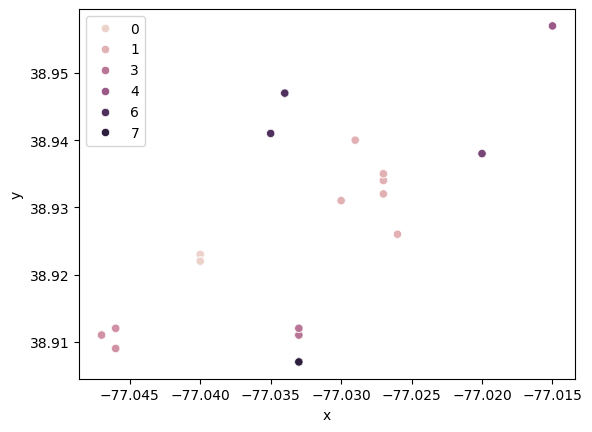

In [16]:
K = 8

valid_geometries = [point for point in tickets_and_routes.geometry if point is not None]
X = np.array([(point.centroid.x, point.centroid.y) for point in valid_geometries])
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(X)
sns.scatterplot(data = pd.DataFrame(X, columns=['x', 'y']), x = 'x', y = 'y', hue = kmeans.labels_)

In [37]:
import datetime

array_data = []
for index, row in tickets.iterrows():
  if row.geometry and row.geometry.is_valid and not row.geometry.is_empty:
    x_coord = row.geometry.x
    y_coord = row.geometry.y
    date = row['ISSUE_DATE'].date()

    try:
        time_of_day = datetime.time(int(row['ISSUE_TIME'].zfill(4)[:2]), int(row['ISSUE_TIME'].zfill(4)[2:]))
    except (ValueError, TypeError):
        print(f"Invalid time format: {row['ISSUE_TIME']}, skipping row")
        continue

    day_of_week =  row['ISSUE_DATE'].date().isoweekday()
    array_data.append([x_coord, y_coord, date, time_of_day, day_of_week])

X_full = np.array(array_data)

# Train a logistic regression model to predict whether any x, y coordinate in DC will be close to a parking ticket cluster

To-do: add inputs for date and time like X_full above

In [48]:
# Define a function to calculate the distance between two points in miles
def calculate_distance_miles(point1, point2):
    geod = pyproj.Geod(ellps='WGS84')
    angle1, angle2, distance = geod.inv(point1.x, point1.y, point2.x, point2.y)
    return distance / 1609.34  # Convert meters to miles

# Create a list to store the features and labels
features = []
labels = []

# Iterate through each geometry in zones gdf (X, Y within DC)
for geometry in zones.geometry:
    if geometry is not None:
        # Iterate through each cluster centroid
        for cluster_label in range(len(np.unique(kmeans.labels_))):
            cluster_centroid = X[kmeans.labels_ == cluster_label].mean(axis=0)
            cluster_centroid_point = Point(cluster_centroid[0], cluster_centroid[1])
            distance = calculate_distance_miles(geometry.centroid, cluster_centroid_point)

            # Create feature vector (distance)
            feature = [distance]
            features.append(feature)

            # Create label (1 if within 3 blocks, 0 otherwise)
            label = 1 if distance <= 0.15 else 0
            labels.append(label)

# Train the logistic regression model
model = LogisticRegression()
model.fit(features, labels)
predictions = model.predict(features)

display(predictions)

# Print model performance metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

print(f"""
Model performance metrics:
--------------------------
Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
F1-score: {f1}
""")

array([0, 0, 0, ..., 0, 0, 0])


Model performance metrics:
--------------------------
Accuracy: 0.9996542080223739
Precision: 1.0
Recall: 0.910871694417238
F1-score: 0.9533572526909277

